Example using dask-gateway with a JupyterHub sandbox, intake-esm (on S3 NetCDF)


Author: A.Radhakrishnan, Feb 2021

using t2.xlarge

In [24]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
import numpy as np
%matplotlib inline

In [25]:
import sys
from dask_gateway import Gateway

def launchDask():
    gateway = Gateway()
    clusters = gateway.list_clusters()
    clusters
    if len(clusters) >0:
        cluster = gateway.connect(clusters[0].name)
        print("using existing connection")
        print(cluster)
    else:
        from dask_gateway import GatewayCluster
        cluster = GatewayCluster()
    return(cluster)

LAUNCH DASK CLUSTER 

In [26]:
cluster = launchDask()
#%pip install ipywidgets

using existing connection
GatewayCluster<pdub.3ff92c2fbf9648c2a9651c45d4a95a65, status=running>


In [27]:
cluster ## see the cluster settings below, we will scale it up in a couple of cells 


In [28]:
from distributed import Client
client = Client(cluster)
client

Client Scheduler: gateway://traefik-pdub-dask-gateway.pdub:80/pdub.3ff92c2fbf9648c2a9651c45d4a95a65 Dashboard: /services/dask-gateway/clusters/pdub.3ff92c2fbf9648c2a9651c45d4a95a65/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


MONITOR THE DASHBOARD from link above

ADAPTIVELY SCALE CLUSTER, so when nothing is going on we use minimum nodes in the setting below.

In [32]:
cluster.adapt(minimum=1, maximum=10)  

We will now use our intake_esm catalog and the intake_esm API for data exploration and search.
Then use xarray and matplotlib as needed. 

Catalog: 

esgf-world.json is the ESM collections spec file for the netCDF data in the S3 bucket esgf-world. The cell below points to the most updated catalog (updated periodically using a CatalogBuilder API)

Other examples can be found here as well:

You can refer to https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/esm-collection-spec-examples for the most recent catalogs
More examples can be found in https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/examples 


In [33]:
col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 

In [34]:
col = intake.open_esm_datastore(col_url)

Examples to just search for what we want from the catalog

In [35]:
expname_filter = ['historical']
table_id_filter = 'Omon'
model_filter = 'GFDL-ESM4'
variable_id_filter = "thetao"
ens_filter = "r1i1p1f1"
#version_filter = "v20190726"
grid_label="gn"
cat = col.search(grid_label="gn",experiment_id=expname_filter, mip_table=table_id_filter,model=model_filter,variable=variable_id_filter,version="v20190726")

In [36]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 1}},storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [37]:
ds = dset_dict['CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Omon']

In [38]:
thetao = ds.thetao
thetao

<xarray.DataArray 'thetao' (ensemble_member: 1, time: 1980, lev: 35, y: 576, x: 720)>
dask.array<broadcast_to, shape=(1, 1980, 35, 576, 720), dtype=float32, chunksize=(1, 1, 35, 576, 720), chunktype=numpy.ndarray>
Coordinates:
    lat              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * time             (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x                (x) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * y                (y) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
  * lev              (lev) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Attributes:
    long_name:      Sea Water Potential Temperature
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    standard_name:  sea_water_potential_temperature
    original_name:  thetao

In [40]:
ds.thetao 

<xarray.DataArray 'thetao' (ensemble_member: 1, time: 1980, lev: 35, y: 576, x: 720)>
dask.array<broadcast_to, shape=(1, 1980, 35, 576, 720), dtype=float32, chunksize=(1, 1, 35, 576, 720), chunktype=numpy.ndarray>
Coordinates:
    lat              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * time             (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x                (x) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * y                (y) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
  * lev              (lev) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Attributes:
    long_name:      Sea Water Potential Temperature
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    standard_name:  sea_water_potential_temperature
    original_name:  thetao

CPU times: user 1.79 s, sys: 174 ms, total: 1.96 s
Wall time: 5min 30s


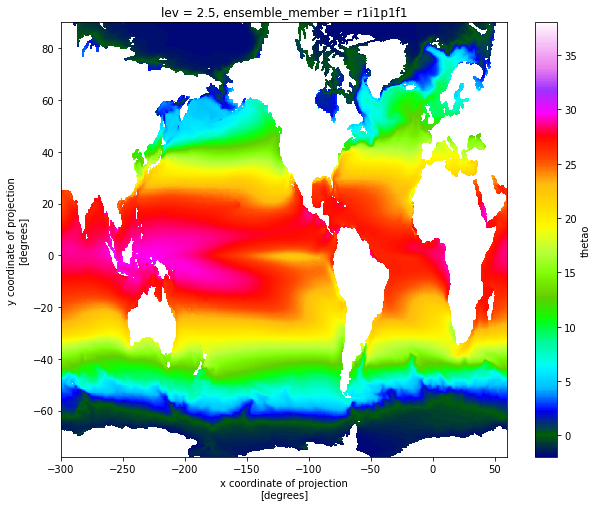

In [41]:
thetao_mean = thetao.sel(lev=2.5).mean(dim='time')
%time thetao_mean.plot(figsize=[10,8], vmin=-2, vmax=38, cmap='gist_ncar')

In [28]:
cluster.close()
client.close()